# Data_Cleaning, Data_Engineering, Data_Visualizations

## Oil (Energy) Group

### 1. Load Data & Define Skeleton

**Explanation:** We load the main stock dataset just to grab the unique date list (the Skeleton). We also load the raw Oil file.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define Directories
raw_dir = r"D:\MS_Data_Science_Thesis\Data_Extraction\Raw_Data_Folder"
semi_clean_dir = r"D:\MS_Data_Science_Thesis\Data_Cleaning\Semi_Clean_Datasets"

# 1. Load the "Skeleton" (The Stock Data)
# We need this to know which dates we MUST have.
stock_path = os.path.join(semi_clean_dir, "stock_senti_engineered_imputed_2.csv")
df_skeleton = pd.read_csv(stock_path)
df_skeleton['date'] = pd.to_datetime(df_skeleton['date'])

# Extract unique dates to create the Master Timeline
unique_dates = pd.DataFrame(df_skeleton['date'].unique(), columns=['date']).sort_values('date')

# 2. Load the Raw Oil Data
oil_path = os.path.join(raw_dir, "oil_prices_long.csv")
df_oil_raw = pd.read_csv(oil_path)
df_oil_raw['date'] = pd.to_datetime(df_oil_raw['date'])

print(f"Skeleton Dates: {len(unique_dates)}")
print(f"Raw Oil Rows: {len(df_oil_raw)}")
df_oil_raw.head()

Skeleton Dates: 3443
Raw Oil Rows: 8404


,date,price,benchmark
0,2010-01-01,NaN,WTI
1,2010-01-04,81.52,WTI
2,2010-01-05,81.74,WTI
3,2010-01-06,83.12,WTI
4,2010-01-07,82.60,WTI


### 2. Filter WTI & Merge

**Explanation:** We isolate WTI. Then we Left Join WTI onto the unique_dates skeleton.

**Critical Step:** Forward Fill (ffill). Oil markets close on different holidays than stock markets. If Stock Market is Open but Oil is Closed, we assume Oil price = Yesterday's Price.

In [10]:
# 1. Filter for WTI only (Addressing the Conundrum)
df_wti = df_oil_raw[df_oil_raw['benchmark'] == 'WTI'].copy()

# Rename columns for clarity before merge
df_wti = df_wti.rename(columns={'price': 'Oil_Price'})
df_wti = df_wti[['date', 'Oil_Price']] # Keep only necessary columns

# 2. Merge with Skeleton (Left Join)
# This ensures we have a row for every single day present in your Stock dataset
df_oil_clean = pd.merge(unique_dates, df_wti, on='date', how='left')

# 3. Impute Missing Values (Forward Fill)
# If Oil price is missing (weekend/holiday gap), carry forward the last known price.
df_oil_clean['Oil_Price'] = df_oil_clean['Oil_Price'].ffill()

# Backfill any remaining (e.g., if the dataset starts before the first oil price)
df_oil_clean['Oil_Price'] = df_oil_clean['Oil_Price'].bfill()

print(f"Merged Oil Shape: {df_oil_clean.shape}")
print(f"Missing Values after Imputation: {df_oil_clean['Oil_Price'].isna().sum()}")
df_oil_clean.head()

Merged Oil Shape: (3443, 2)
Missing Values after Imputation: 0


,date,Oil_Price
0,2010-04-27,82.43
1,2010-04-28,83.22
2,2010-04-29,85.17
3,2010-04-30,86.07
4,2010-05-03,86.19


### 3. Load Data & Define Skeleton

**Explanation:** Calculating Log Returns (Essential), RSI, and Volatility.

In [13]:
# Helper Function for RSI
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# 1. Log Returns (The most important feature for Stationarity)
df_oil_clean['Oil_Log_Return'] = np.log(df_oil_clean['Oil_Price'] / df_oil_clean['Oil_Price'].shift(1))

# 2. RSI (14-Day Momentum)
df_oil_clean['Oil_RSI'] = calculate_rsi(df_oil_clean['Oil_Price'])

# 3. Moving Averages (Trend)
df_oil_clean['Oil_MA7'] = df_oil_clean['Oil_Price'].rolling(window=7).mean()
df_oil_clean['Oil_MA50'] = df_oil_clean['Oil_Price'].rolling(window=50).mean()

# 4. Volatility (7-Day Rolling Standard Deviation of Returns)
# This captures "Oil Market Fear"
df_oil_clean['Oil_Vol7'] = df_oil_clean['Oil_Log_Return'].rolling(window=7).std()

# Drop NaNs generated by rolling windows (optional, or keep them)
# For the standalone file, we'll keep them to preserve the dates, but fill with 0 or bfill? 
# Usually better to drop the first few rows later in the final merge.
# For now, let's leave them as NaN to be transparent.

print("Oil Feature Engineering Complete.")
df_oil_clean.tail()

Oil Feature Engineering Complete.


C:\Users\siddh\anaconda3\envs\sidd_ds\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,date,Oil_Price,Oil_Log_Return,Oil_RSI,Oil_MA7,Oil_MA50,Oil_Vol7
3438,2023-12-21,73.59,-0.003798,49.646757,72.028571,78.0402,0.011574
3439,2023-12-22,73.29,-0.004085,51.879195,72.628571,77.8486,0.012811
3440,2023-12-26,75.84,0.034202,61.667666,73.290000,77.6120,0.013975
3441,2023-12-27,74.31,-0.020380,67.498359,73.755714,77.3652,0.017613
3442,2023-12-28,72.02,-0.031302,58.628571,73.735714,77.0724,0.021939


### 4. Save Semi-Clean Oil Dataset

**Explanation:** Saving this as a separate module, as per your "Phase 2" plan.

In [16]:
output_path = os.path.join(semi_clean_dir, "oil_engineered_3.csv")
df_oil_clean.to_csv(output_path, index=False)
print(f"Saved processed Oil data to: {output_path}")

Saved processed Oil data to: D:\MS_Data_Science_Thesis\Data_Cleaning\Semi_Clean_Datasets\oil_engineered_3.csv


### 5. The Overlay Visualizations (Stock Price vs. Oil Price)

**Explanation:** You asked for 7 graphs. Since there is only 1 Oil Price, it makes sense to plot Stock Price (Left Axis) vs. Oil Price (Right Axis) for each of your 7 tickers. This visually confirms the correlation.

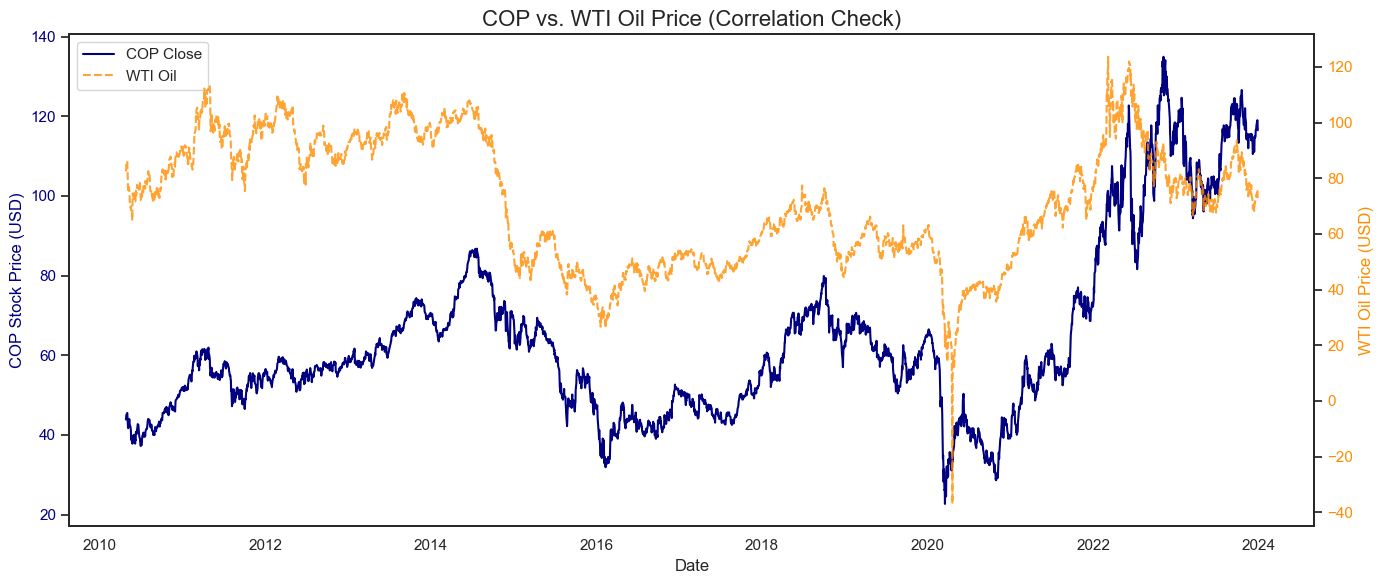

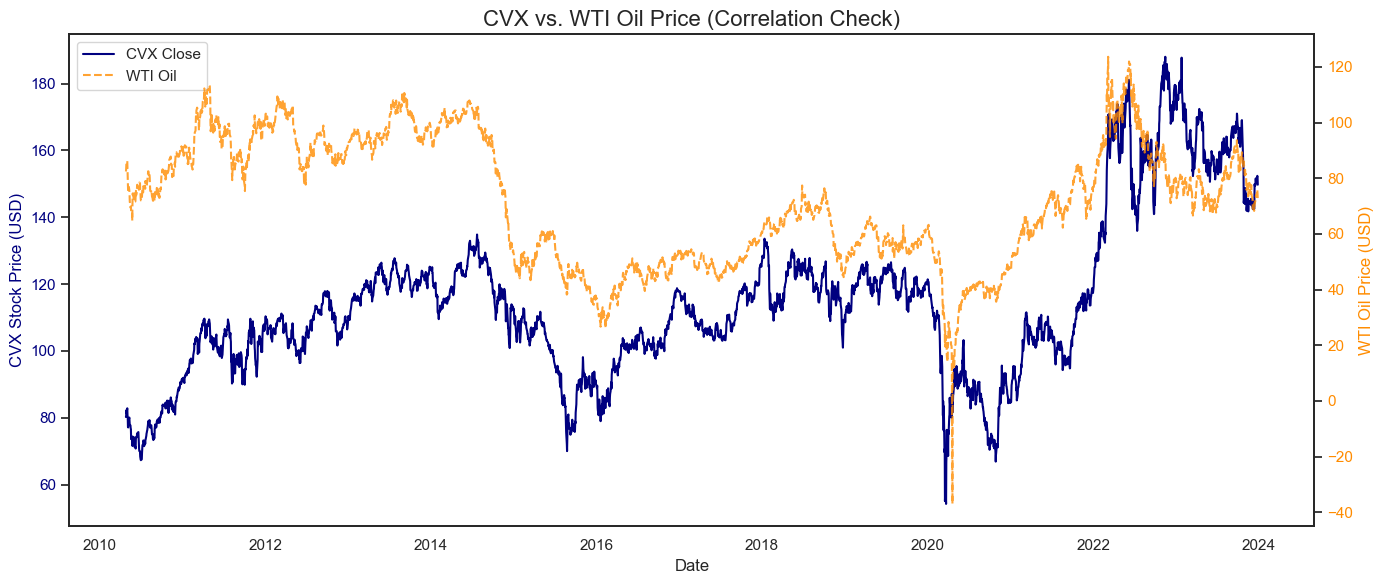

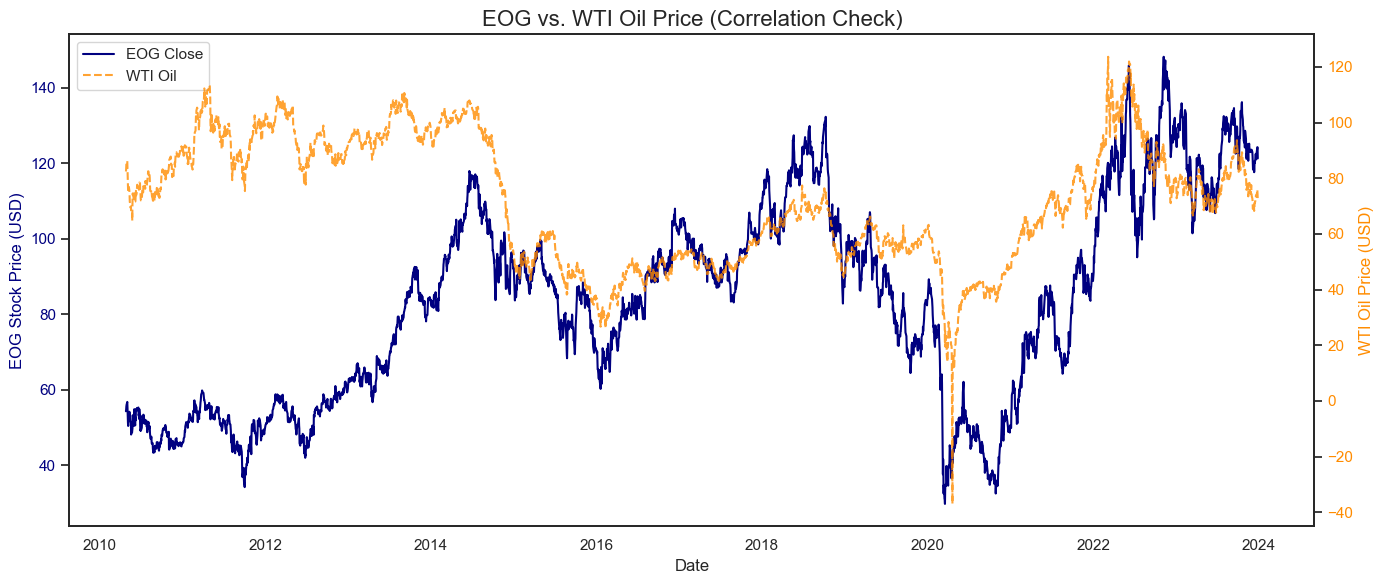

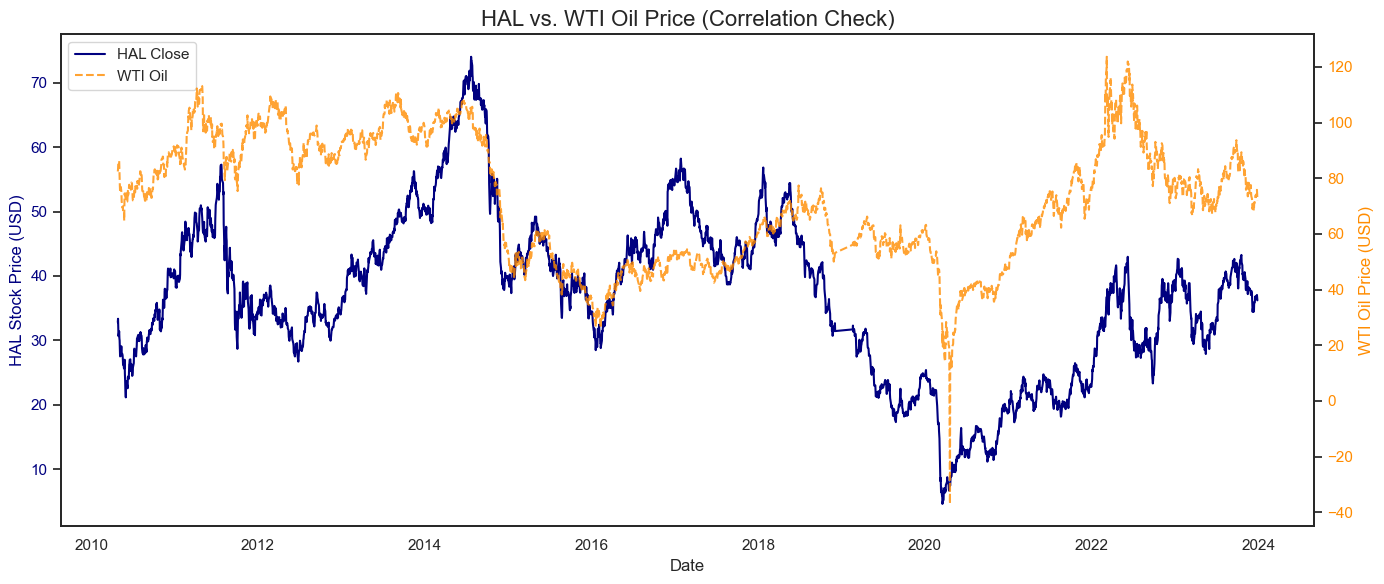

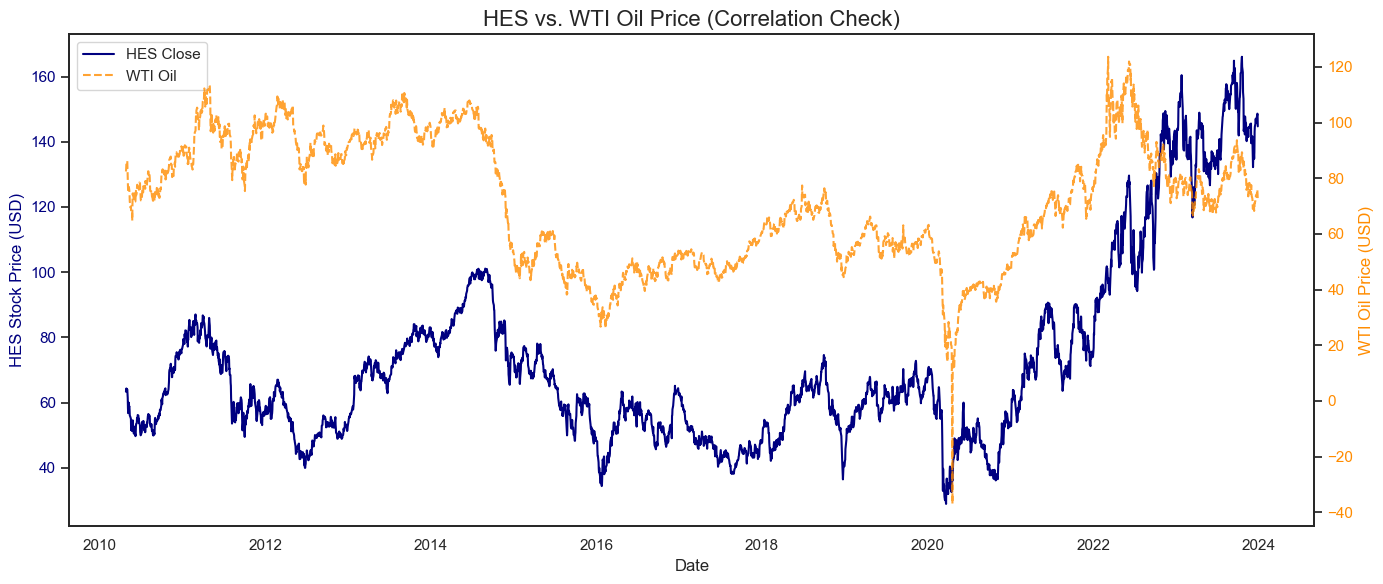

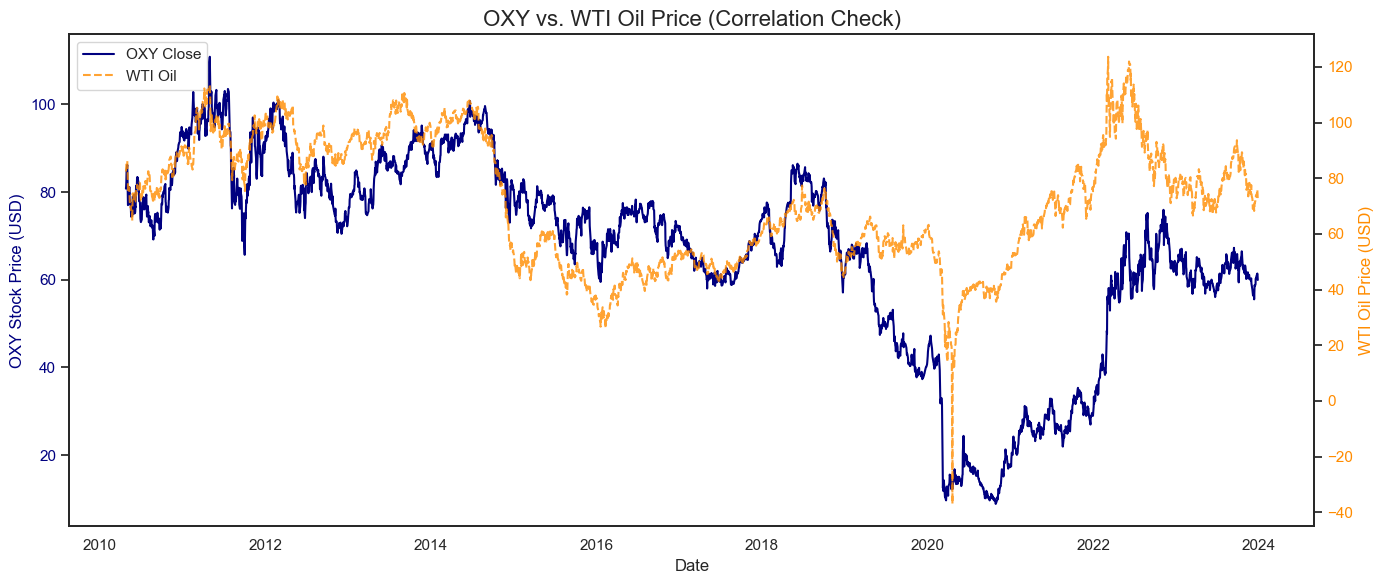

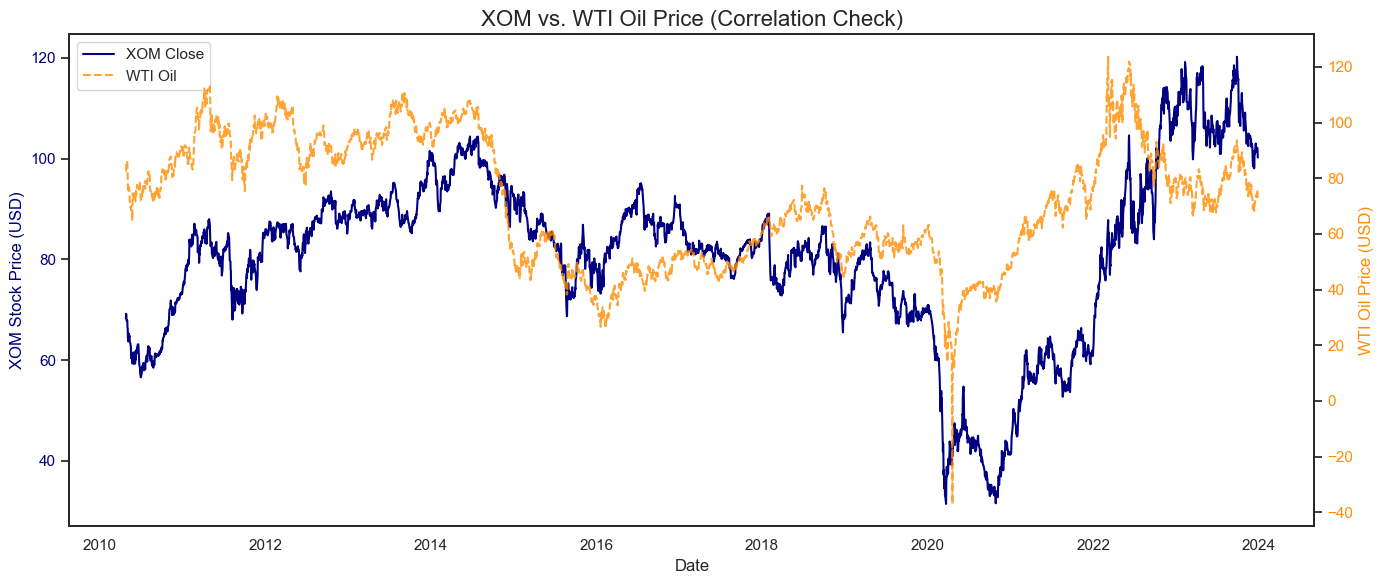

In [19]:
# We need to merge temporarily just for plotting
# We use the loaded 'df_skeleton' (which has stock prices) and 'df_oil_clean'
plot_df = pd.merge(df_skeleton, df_oil_clean, on='date', how='left')

tickers = plot_df['ticker'].unique()
sns.set(style="white")

for t in tickers:
    subset = plot_df[plot_df['ticker'] == t]
    
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # 1. Stock Price (Left Axis)
    color1 = 'navy'
    ax1.set_xlabel('Date')
    ax1.set_ylabel(f'{t} Stock Price (USD)', color=color1, fontsize=12)
    ax1.plot(subset['date'], subset['close'], color=color1, label=f'{t} Close', linewidth=1.5)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    # 2. Oil Price (Right Axis)
    ax2 = ax1.twinx()  
    color2 = 'darkorange'
    ax2.set_ylabel('WTI Oil Price (USD)', color=color2, fontsize=12)
    # Using a dashed line for Oil to distinguish it
    ax2.plot(subset['date'], subset['Oil_Price'], color=color2, label='WTI Oil', linestyle='--', alpha=0.8)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    plt.title(f"{t} vs. WTI Oil Price (Correlation Check)", fontsize=16)
    
    # Manual Legend to combine both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
    
    plt.tight_layout()
    plt.show()